In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from pushover import notify
from utils import makegif
from random import randint
import numpy as np

import IPython
from IPython.display import Image
from IPython.core.display import Image, display
import PIL

import piano_roll_utils
import librosa
import librosa.display

%load_ext autoreload
%autoreload 2

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
bs = 32 # batchsize

In [4]:
# Load Data

def load_img(img_path):
    img = PIL.Image.open(img_path)
    img = img.convert(mode="L")
#     npimg = np.array(img)/256.0
    return img
IMRANGE = 256 # uint8

dataset = datasets.ImageFolder(root='trainings/rolls_gray', transform=transforms.Compose([
    transforms.ToTensor(), 
    lambda x: x > 0,
    lambda x: x.type(torch.FloatTensor),
]), loader=load_img)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)

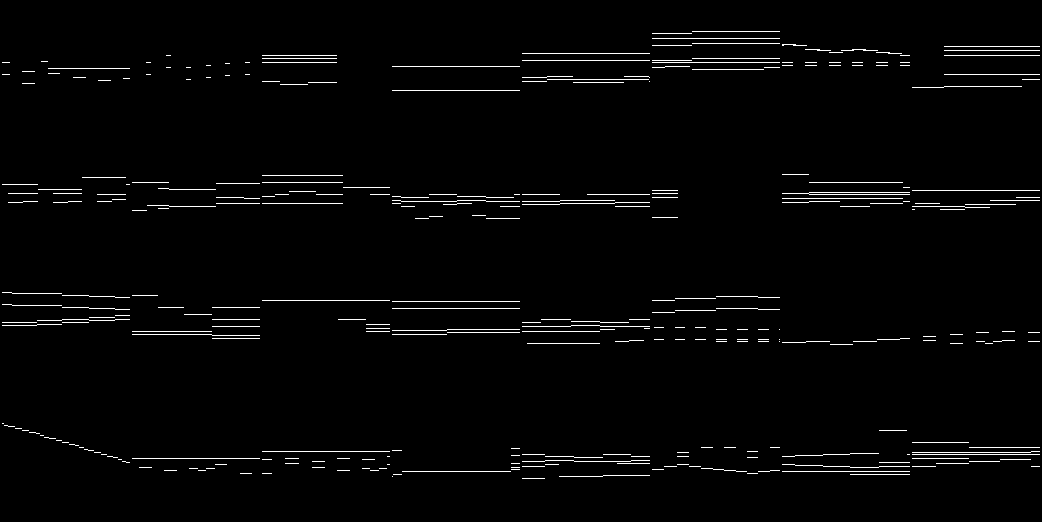

In [5]:
# Fixed input for debugging
fixed_x, _ = next(iter(dataloader))
save_image(fixed_x, 'tmp/real_image.png')

Image('tmp/real_image.png')

In [6]:
print(dataset[1][0].shape)
HSIZE = 2048 #9216 # 1024
ZDIM =  16 # 32

torch.Size([1, 128, 128])


In [7]:
# def get_player(piano_roll):
#     midi= piano_roll_utils.piano_roll_to_pretty_midi(piano_roll, fs=50, program=11)
#     IPython.display.Audio(midi.fluidsynth(fs=44100),rate=44100)

In [8]:
rand_i = 0 #randint(1, 100)
print(rand_i)

0


In [9]:
sample = dataset[rand_i][0].unsqueeze(0)[0][0]
for_play = np.array(sample).astype(int) * 64
midi= piano_roll_utils.piano_roll_to_pretty_midi(for_play,fs=50,program=11)
IPython.display.Audio(midi.fluidsynth(fs=44100),rate=44100)

In [10]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [11]:
class UnFlatten(nn.Module):
    def forward(self, input, size=HSIZE):
        return input.view(input.size(0), size, 1, 1)

In [12]:
class VAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=HSIZE, z_dim=ZDIM):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2), # -> [32, 32, 31, 31] 63
            nn.BatchNorm2d(32),
            nn.Tanh(),
#             nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), # -> [32, 64, 14, 14] 31
            nn.BatchNorm2d(64),
            nn.Tanh(),
#             nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2), # -> [32, 128, 6, 6] 14
            nn.BatchNorm2d(128),
            nn.Tanh(),
#             nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2), # -> [32, 256, 2, 2] 6
            nn.BatchNorm2d(256),
            nn.Tanh(),
#             nn.ReLU(), 
            nn.Conv2d(256, 512, kernel_size=4, stride=2), # -> Null -> [32, 512, 2, 2] 
            nn.BatchNorm2d(512),
            nn.Tanh(),
#             nn.ReLU(), 
            Flatten() # -> [32, 1024]  -> [32, 2048]
#             # [32, a, b, c] -> [32, abc]
        )
#         self.relu = nn.Sequential(nn.Tanh())
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(), 
            nn.ConvTranspose2d(h_dim, 256 , kernel_size=5, stride=2),
            nn.BatchNorm2d(256),
            nn.Tanh(),
#             nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2),
            nn.BatchNorm2d(128),
            nn.Tanh(),
#             nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.BatchNorm2d(64),
            nn.Tanh(),
#             nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.BatchNorm2d(32),
            nn.Tanh(),
#             nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.BatchNorm2d(image_channels),
            nn.Sigmoid(),
        )
#         self.decoder = nn.Sequential(
#             UnFlatten(),
#             nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
#             nn.Sigmoid(),
#         )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
#         print("bottle: ",mu.shape, logvar.shape)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
#         print("======== Encode ========", x.shape)
        h = self.encoder(x)
#         print("enc(x): ", h.shape, print_elems_gt(h, 1))
#         print("relu(enc): ", self.relu(h))
        z, mu, logvar = self.bottleneck(h)
#         print("z.shape: ", z.shape)
        return z, mu, logvar

    def decode(self, z):
#         print("======== Decode ========", z.shape)
        z = self.fc3(z)
#         print("fc3(z).shape: ", z.shape)
        z = self.decoder(z)
#         print("decode(fc3(z)).shape: ", z.shape)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
#         print(z.shape)
        z = self.decode(z)
#         print(z.shape, mu.shape, logvar.shape)
        return z, mu, logvar

In [13]:
image_channels = fixed_x.size(1)

In [14]:
model = VAE(image_channels=image_channels).to(device)
# cvae.graybin_bce_d16_bn_relu-imgs_2297-epch_250-300
model_version = "graybin_bce_d16_bn-imgs_2297-epch_210-300" #"graybin_bce_d16_bn_relu-imgs_2297-epch_250-300"  #"graybin_bce_batch32-imgs_2297-epch_75-100"# "graybin_bce_d16-imgs_2297-epch_100" 
model.load_state_dict(torch.load('models/cvae.' + model_version, map_location='cpu'))

In [15]:
def print_gt_zero_elem(matrix):
    print(get_elems(matrix))
    
def get_elems(matrix, thres=0.1):
    return matrix[matrix >= thres]

In [16]:
rand_i = randint(1, 100)
print(rand_i)

10


In [17]:
fixed_x = dataset[rand_i][0].unsqueeze(0)
fixed_x2 = fixed_x.clone()

In [18]:
def compare(x):
    recon_x, _, _ = model(x)
    recon_x2 = recon_x.clone()
    print("val", recon_x2.max())
#     recon_pass = recon_x2[0][0]
    recon_pass = (recon_x2>0.999).type(torch.FloatTensor) #* recon_x2
    print("recon:", get_elems(recon_x, thres=0.01))
    print("original:", get_elems(x, thres=0.01))
    return torch.cat([x * 64.0, recon_pass * 64.0]), recon_pass

In [19]:
for_play = np.array(fixed_x2[0][0]).astype(int) * 64
midi= piano_roll_utils.piano_roll_to_pretty_midi(for_play,fs=50,program=11)
IPython.display.Audio(midi.fluidsynth(fs=44100),rate=44100)

In [20]:
compare_x, recon_x = compare(fixed_x)

val tensor(1., grad_fn=<MaxBackward1>)
recon: tensor([0.0113, 0.0123, 0.0146,  ..., 0.0209, 0.0260, 0.0140],
       grad_fn=<IndexBackward>)
original: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [21]:
for_play = np.array(recon_x[0][0].data.cpu()) * 64
midi= piano_roll_utils.piano_roll_to_pretty_midi(for_play.astype(int) ,fs=50,program=11)
IPython.display.Audio(midi.fluidsynth(fs=44100),rate=44100)

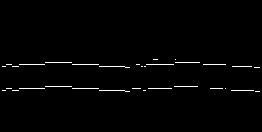

In [22]:
sample_filename = 'outputs/sample_image-{}.png'.format(model_version)
save_image(compare_x.data.cpu(), sample_filename)
display(Image(sample_filename, width=300, unconfined=True))

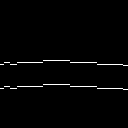

tensor([[  6.9553,  -2.1601,  10.6841,   1.1943, -12.4678, -11.4191,  -6.4432,
         -19.0915,  -2.3297,   2.9103,   0.3070,   1.0996, -12.5413,   7.5499,
          -0.1056,  -8.5270]], grad_fn=<AddBackward0>)
tensor([[[[0.0024, 0.0011, 0.0014,  ..., 0.0007, 0.0009, 0.0020],
          [0.0025, 0.0033, 0.0016,  ..., 0.0008, 0.0007, 0.0007],
          [0.0029, 0.0018, 0.0010,  ..., 0.0008, 0.0010, 0.0026],
          ...,
          [0.0056, 0.0025, 0.0030,  ..., 0.0018, 0.0005, 0.0017],
          [0.0015, 0.0015, 0.0017,  ..., 0.0011, 0.0014, 0.0011],
          [0.0019, 0.0012, 0.0022,  ..., 0.0036, 0.0019, 0.0012]]]],
       grad_fn=<SigmoidBackward>)


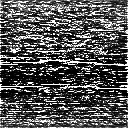

In [23]:
save_image(fixed_x2 * 256, 'tmp/test.png', padding=0)
display(Image('tmp/test.png'))
z, mu, log_var = model.encode(fixed_x2)
print(z)
x = model.decode(z)
print(x)
save_image(x[0][0] * 256, 'tmp/test.png', padding=0)
display(Image('tmp/test.png'))

In [24]:
m = nn.BatchNorm2d(100)
# Without Learnable Parameters
m = nn.BatchNorm2d(1, affine=False)
input = torch.randn(20, 100, 35, 45)
test = torch.Tensor([[[[-5.7798,  2.1175,  1.8994, -1.1060,  2.9570,  1.2670,  1.6456,  1.1319,
          0.3539, -3.7390, -7.2136, -0.0291, -1.3198,  0.5766,  1.1158,  2.6609]]]])
output = m(test)

In [25]:
test

tensor([[[[-5.7798,  2.1175,  1.8994, -1.1060,  2.9570,  1.2670,  1.6456,
            1.1319,  0.3539, -3.7390, -7.2136, -0.0291, -1.3198,  0.5766,
            1.1158,  2.6609]]]])

In [ ]:
output

In [ ]:
xs = torch.randn((128,8,32,32))

In [ ]:
xs